# Elo world 

In this kernel, I build a LGBM model that aggregates the `new_merchant_transactions.csv` and `historical_transactions.csv` tables to the main train table. New features are built by successive grouping on`card_id` and `month_lag`, in order to recover some information from the time serie.

During the competition, I took into account the enlightments provided by others kernels, and included a few features that appeared to be important. In particular, I closely looked at the following kernels (ordered by release time):
1.  [You're Going to Want More Categories [LB 3.737] by Peter Hurford](https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737)
2. [EloDA with Feature Engineering and Stacking by Bojan Tunguz](https://www.kaggle.com/tunguz/eloda-with-feature-engineering-and-stacking)
3. [A Closer Look at Date Variables by Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables)
4. [LGB + FE (LB 3.707) by Konrad Banachewicz](https://www.kaggle.com/konradb/lgb-fe-lb-3-707)
5. [My first kernel (3.699) by Chau Ngoc Huynh](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/)

## Notebook  Content
1. [Loading the data](#1)
1. [Feature engineering](#2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

<a id="1"></a> <br>
## 1. Loading the data

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [4]:
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('../input/historical_transactions.csv',
                                      parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

We then load the main files, formatting the dates and extracting the target:

In [5]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('../input/train.csv')
test = read_data('../input/test.csv')



In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,92


**EDA**

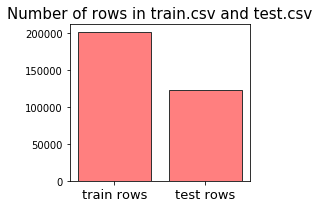

In [7]:
plt.figure(figsize=[4,3])
plt.bar([0, 1], [train.shape[0], test.shape[0]], edgecolor=[0.2]*3, color=(1,0,0,0.5))
plt.xticks([0,1], ['train rows', 'test rows'], fontsize=13)
plt.title('Number of rows in train.csv and test.csv', fontsize=15)
plt.tight_layout()
plt.show()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 7 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
elapsed_time          201917 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 10.8+ MB


In [9]:
train.describe()

,feature_1,feature_2,feature_3,target,elapsed_time
count,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636,381.978981
std,1.186160,0.751362,0.495683,3.850500,293.710176
min,1.000000,1.000000,0.000000,-33.219281,0.000000
25%,2.000000,1.000000,0.000000,-0.883110,153.000000
50%,3.000000,2.000000,1.000000,-0.023437,306.000000
75%,4.000000,2.000000,1.000000,0.765453,488.000000
max,5.000000,3.000000,1.000000,17.965068,2284.000000


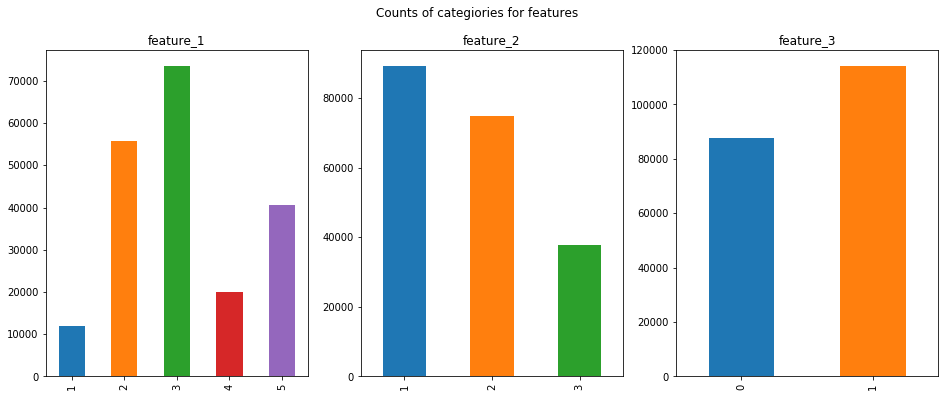

In [10]:
fig, ax = plt.subplots(1,3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], title='feature_3');
plt.suptitle('Counts of categiories for features');

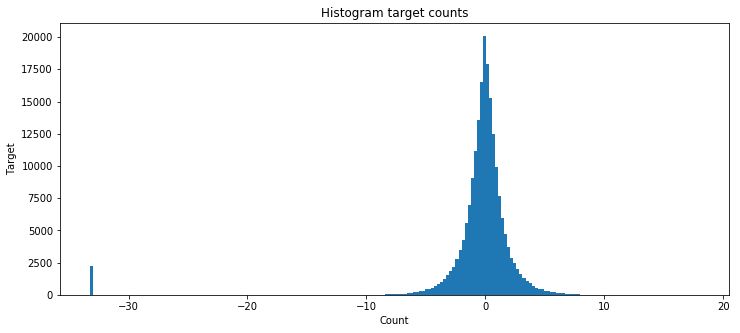

There are 2207 samples in the target equal to -33.21928095.


In [11]:
plt.figure(figsize=(12, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()
print(f'There are {train.loc[train.target  == min(train.target)].shape[0]} samples in the target equal to {min(train.target)}.')

<a id="2"></a> <br>
## Feature engineering
Following [Chau Ngoc Huynh's kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/), I add the following features:

In [12]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [13]:
target = train['target']
del train['target']

In [14]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

#hoidays source https://www.officeholidays.com/countries/brazil/2017 , https://www.officeholidays.com/countries/brazil/2018 
#including Christmas Eve, New Year's Eve and Black Awareness Day
holiday_dates = pd.to_datetime( ['01-01-2017','27-02-2017','28-02-2017','01-02-2017','14-04-2017','21-04-2017','01-05-2017','15-06-2017','07-09-2017',
                    '12-10-2017','01-11-2017','02-11-2017','15-11-2017','20-11-2017','24-12-2017','25-12-2017','31-12-2017',
                    '01-01-2018', '12-02-2018', '13-02-2018','30-03-2018','21-04-2018','01-05-2018','31-05-2018','07-09-2018',
                    '12-10-2018','02-11-2018','15-11-2018','20-11-2018','24-12-2018','25-12-2018','31-12-2018'] ,format="%d-%m-%Y")

historical_transactions["holiday_purchase"] = np.where(historical_transactions["purchase_date"].isin(holiday_dates) , 1, 0)
new_transactions["holiday_purchase"] = np.where(new_transactions["purchase_date"].isin(holiday_dates) , 1, 0)

In [15]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19,68
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19,68
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14,68
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8,69
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29,68


In [16]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,68
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,68
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,69
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,69
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,69


In [17]:

#Convert categorical variable into dummy/indicator variables.
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])


historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)


agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)


authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [18]:
historical_transactions[:5] 

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,69,1,0,0,0,0,1,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,68,1,0,0,0,0,1,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,68,1,0,0,0,0,1,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,68,1,0,0,0,0,1,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,69,1,0,0,0,0,1,0,0


In [19]:
authorized_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,68,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,68,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,69,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,69,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,69,1,0,0,0,0,1,0,0


First, following [Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables) analysis, I define a few dates features:

In [20]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

Then I define two functions that aggregate the info contained in these two tables. The first function aggregates the function by grouping on `card_id`:

In [21]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['sum','mean'],
    'category_2_2.0': ['sum','mean'],
    'category_2_3.0': ['sum','mean'],
    'category_2_4.0': ['sum','mean'],
    'category_2_5.0': ['sum','mean'],
    'category_3_A': ['sum','mean'],
    'category_3_B': ['sum','mean'],
    'category_3_C': ['sum','mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean','max', 'min', 'std'],
    'holiday_purchase': ['sum']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history



In [22]:

history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_2.0_sum,hist_category_2_2.0_mean,hist_category_2_3.0_sum,hist_category_2_3.0_mean,hist_category_2_4.0_sum,hist_category_2_4.0_mean,hist_category_2_5.0_sum,hist_category_2_5.0_mean,hist_category_3_A_sum,hist_category_3_A_mean,hist_category_3_B_sum,hist_category_3_B_mean,hist_category_3_C_sum,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,hist_month_diff_std
0,C_ID_00007093c1,35,4.0,0.114286,0.0,0.000000,0,0.000000,31,0.885714,0.0,0.0,0.0,0.000000,0.0,0.000000,29.0,0.828571,6.0,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,68.171429,69,68,0.382385
1,C_ID_0001238066,3,0.0,0.000000,1.0,0.333333,0,0.000000,0,0.000000,0.0,0.0,2.0,0.666667,0.0,0.000000,3.0,1.000000,0.0,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,68.000000,68,68,0.000000
2,C_ID_0001506ef0,4,0.0,0.000000,0.0,0.000000,0,0.000000,4,1.000000,0.0,0.0,0.0,0.000000,3.0,0.750000,1.0,0.250000,0.0,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,68.500000,69,68,0.577350
3,C_ID_0001793786,27,2.0,0.074074,3.0,0.111111,8,0.296296,3,0.111111,0.0,0.0,0.0,0.000000,22.0,0.814815,5.0,0.185185,0.0,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,72.296296,73,72,0.465322
4,C_ID_000183fdda,7,0.0,0.000000,0.0,0.000000,0,0.000000,7,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,3.0,0.428571,4.0,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,68.285714,69,68,0.487950


In [23]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_sum,auth_category_2_1.0_mean,auth_category_2_2.0_sum,auth_category_2_2.0_mean,auth_category_2_3.0_sum,auth_category_2_3.0_mean,auth_category_2_4.0_sum,auth_category_2_4.0_mean,auth_category_2_5.0_sum,auth_category_2_5.0_mean,auth_category_3_A_sum,auth_category_3_A_mean,auth_category_3_B_sum,auth_category_3_B_mean,auth_category_3_C_sum,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,auth_month_diff_std
0,C_ID_00007093c1,114,24.0,0.210526,0.0,0.000000,0.0,0.000000,89.0,0.780702,0.0,0.0,1.0,0.008772,0.0,0.0,96.0,0.842105,18.0,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,68.447368,69,68,0.499417
1,C_ID_0001238066,120,2.0,0.016667,94.0,0.783333,0.0,0.000000,0.0,0.000000,0.0,0.0,18.0,0.150000,0.0,0.0,85.0,0.708333,32.0,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,68.250000,69,68,0.434828
2,C_ID_0001506ef0,62,0.0,0.000000,2.0,0.032258,0.0,0.000000,60.0,0.967742,0.0,0.0,0.0,0.000000,62.0,1.0,0.0,0.000000,0.0,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,68.354839,69,68,0.482370
3,C_ID_0001793786,189,0.0,0.000000,8.0,0.042328,68.0,0.359788,12.0,0.063492,0.0,0.0,0.0,0.000000,189.0,1.0,0.0,0.000000,0.0,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,72.232804,73,72,0.423741
4,C_ID_000183fdda,137,4.0,0.029197,7.0,0.051095,1.0,0.007299,124.0,0.905109,0.0,0.0,1.0,0.007299,0.0,0.0,100.0,0.729927,33.0,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,68.277372,69,68,0.449345


In [24]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_2.0_sum,new_category_2_2.0_mean,new_category_2_3.0_sum,new_category_2_3.0_mean,new_category_2_4.0_sum,new_category_2_4.0_mean,new_category_2_5.0_sum,new_category_2_5.0_mean,new_category_3_A_sum,new_category_3_A_mean,new_category_3_B_sum,new_category_3_B_mean,new_category_3_C_sum,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,new_month_diff_max,new_month_diff_min,new_month_diff_std
0,C_ID_00007093c1,2,0,0.000000,1,0.500000,0,0.000000,1,0.50000,0,0.0,0,0.000000,0,0.0,2,1.000000,0,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,68.500000,69,68,0.707107
1,C_ID_0001238066,26,2,0.076923,20,0.769231,0,0.000000,0,0.00000,0,0.0,3,0.115385,0,0.0,21,0.807692,4,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,68.153846,69,68,0.367946
2,C_ID_0001506ef0,2,0,0.000000,0,0.000000,0,0.000000,2,1.00000,0,0.0,0,0.000000,2,1.0,0,0.000000,0,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,68.000000,68,68,0.000000
3,C_ID_0001793786,31,0,0.000000,15,0.483871,8,0.258065,5,0.16129,0,0.0,1,0.032258,31,1.0,0,0.000000,0,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,72.000000,72,72,0.000000
4,C_ID_000183fdda,11,0,0.000000,0,0.000000,0,0.000000,11,1.00000,0,0.0,0,0.000000,0,0.0,6,0.545455,4,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,68.454545,69,68,0.522233


The second function first aggregates on the two variables `card_id` and `month_lag`. Then a second grouping is performed to aggregate over time:

In [25]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557395,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [27]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')


In [28]:
#Grouping month lag data (auth month-13, auth month-12 and etc.) for count purchases, and sum adjusted purchase_amount, std, min, max)

def aggregate_date(history):

    grouped = history.groupby(['card_id','purchase_date'])

    agg_func = {
            'purchase_amount': ['sum', 'mean', 'min', 'max', 'std'],
            'installments': ['sum', 'mean', 'min', 'max', 'std'],
             }
 

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]

    intermediate_group.reset_index(inplace=True)
    final_group = intermediate_group.groupby('card_id').agg(['mean','std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
x =  aggregate_date(historical_transactions) 
x[:10]


,card_id,purchase_date_mean,purchase_date_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,1.502751e+09,9.092175e+06,-0.411485,0.430059,-0.411485,0.430059,-0.411485,0.430059,-0.411485,0.430059,NaN,NaN,1.285714,0.667367,1.285714,0.667367,1.285714,0.667367,1.285714,0.667367,NaN,NaN
1,C_ID_0001238066,1.515863e+09,2.083731e+06,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN
2,C_ID_0001506ef0,1.511659e+09,1.031806e+07,-0.726445,0.016203,-0.726445,0.016203,-0.726445,0.016203,-0.726445,0.016203,NaN,NaN,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,NaN,NaN
3,C_ID_0001793786,1.498788e+09,6.491738e+06,-0.437975,0.498150,-0.437975,0.498150,-0.437975,0.498150,-0.437975,0.498150,NaN,NaN,0.185185,0.395847,0.185185,0.395847,0.185185,0.395847,0.185185,0.395847,NaN,NaN
4,C_ID_000183fdda,1.504129e+09,2.262857e+06,-0.134483,0.452741,-0.134483,0.452741,-0.134483,0.452741,-0.134483,0.452741,NaN,NaN,2.714286,2.288689,2.714286,2.288689,2.714286,2.288689,2.714286,2.288689,NaN,NaN
5,C_ID_00024e244b,1.506548e+09,8.501619e+06,-0.488624,0.415206,-0.488624,0.415206,-0.488624,0.415206,-0.488624,0.415206,NaN,NaN,0.294118,0.469668,0.294118,0.469668,0.294118,0.469668,0.294118,0.469668,NaN,NaN
6,C_ID_0002709b5a,1.504874e+09,1.350371e+07,-0.619784,0.135662,-0.619784,0.135662,-0.619784,0.135662,-0.619784,0.135662,NaN,NaN,1.833333,2.041241,1.833333,2.041241,1.833333,2.041241,1.833333,2.041241,NaN,NaN
7,C_ID_00027503e2,1.504394e+09,6.988880e+06,-0.741570,0.003383,-0.741570,0.003383,-0.741570,0.003383,-0.741570,0.003383,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
8,C_ID_000298032a,1.499012e+09,1.014387e+07,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,1.501473e+09,7.469866e+06,-0.618979,0.105717,-0.618979,0.105717,-0.618979,0.105717,-0.618979,0.105717,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [29]:
y =  aggregate_date(new_transactions) 
y[:10]


,card_id,purchase_date_mean,purchase_date_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,1.523023e+09,3.797333e+05,-0.664062,0.010704,-0.664062,0.010704,-0.664062,0.010704,-0.664062,0.010704,NaN,NaN,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN
1,C_ID_0001238066,1.522335e+09,1.528160e+06,-0.571289,0.173462,-0.571289,0.173462,-0.571289,0.173462,-0.571289,0.173462,NaN,NaN,1.615385,2.079941,1.615385,2.079941,1.615385,2.079941,1.615385,2.079941,NaN,NaN
2,C_ID_0001506ef0,1.521474e+09,3.331548e+05,-0.723633,0.011742,-0.723633,0.011742,-0.723633,0.011742,-0.723633,0.011742,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
3,C_ID_0001793786,1.512367e+09,1.394049e+06,-0.007866,1.166992,-0.116333,0.800293,-0.144531,0.751465,-0.062622,0.955078,1.349609,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
4,C_ID_000183fdda,1.521578e+09,1.879765e+06,-0.599121,0.182861,-0.599121,0.182861,-0.599121,0.182861,-0.599121,0.182861,NaN,NaN,1.454545,1.293340,1.454545,1.293340,1.454545,1.293340,1.454545,1.293340,NaN,NaN
5,C_ID_0002709b5a,1.521726e+09,2.901342e+06,-0.672852,0.057770,-0.672852,0.057770,-0.672852,0.057770,-0.672852,0.057770,NaN,NaN,0.333333,1.154701,0.333333,1.154701,0.333333,1.154701,0.333333,1.154701,NaN,NaN
6,C_ID_000298032a,1.522340e+09,NaN,-0.642090,NaN,-0.642090,NaN,-0.642090,NaN,-0.642090,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
7,C_ID_0002ba3c2e,1.510737e+09,2.027473e+06,-0.690430,0.019836,-0.690430,0.019836,-0.690430,0.019836,-0.690430,0.019836,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
8,C_ID_0002c7c2c1,1.519799e+09,1.811436e+06,-0.654785,0.083313,-0.654785,0.083313,-0.654785,0.083313,-0.654785,0.083313,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_00032df08f,1.515883e+09,6.426554e+05,-0.348877,0.366455,-0.348877,0.366455,-0.348877,0.366455,-0.348877,0.366455,NaN,NaN,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN


In [30]:
# def aggregate_catergory3(history):

#     grouped = history.groupby(['card_id','month_lag'])

#     agg_func = {
#              'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
#                 'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
#              }
 

#     intermediate_group = grouped.agg(agg_func)
#     intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]

#     intermediate_group.reset_index(inplace=True)
#     final_group = intermediate_group.groupby('card_id').agg(['mean','std'])
#     final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
#     final_group.reset_index(inplace=True)
    
#     return final_group
# #___________________________________________________________
# y =  aggregate_catergory2(historical_transactions) 
# y[:10]

<a id="3"></a> <br>
## 3. Training the model
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [31]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, x, on='card_id', how='left')
test = pd.merge(test,x, on='card_id', how='left')

train = pd.merge(train, y, on='card_id', how='left')
test = pd.merge(test,y, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [32]:
# cols = [c for c in train if c.startswith('hist')]
# train.loc[train['hist_transactions_count'].isnull(), cols] = 0
# test.loc[test['hist_transactions_count'].isnull(), cols] = 0

# cols = [c for c in train if c.startswith('new')]
# train.loc[train['new_transactions_count'].isnull(), cols] = 0
# test.loc[test['new_transactions_count'].isnull(), cols] = 0

In [33]:
# cols = [c for c in train if c.endswith('std')]
# for c in cols:
#     train.loc[train[c].isnull(), c] = 0
#     test.loc[test[c].isnull(), c] = 0

In [34]:
# train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
# test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']

In [35]:
# hist_columns = [(c, c.replace('new', 'auth')) for c in train.columns if 'hist' in c]
# for c in hist_columns:
#     col_name = 'ratio_{}_{}'.format(c[0], c[1])
#     train[col_name] = train[c[0]] / train[c[1]]
#     test[col_name] = test[c[0]] / test[c[1]]

and to define the features we want to keep to train the model. For that purpose, I use the results obtained in the [Selecting features kernel](https://www.kaggle.com/fabiendaniel/selecting-features/notebook):

In [36]:
# unimportant_features = [
#     'auth_category_2_1.0_mean',
#     'auth_category_2_2.0_mean',
#     'auth_category_2_3.0_mean',
#     'auth_category_2_5.0_mean',
#     'hist_category_2_3.0_mean',
#     'hist_category_2_4.0_mean',
#     'hist_category_2_5.0_mean',
#     'hist_category_3_A_mean',
#     'hist_installments_min',
#     'hist_installments_std',
#     'hist_month_lag_std',
#     'hist_purchase_amount_max',
#     'hist_purchase_month_max',
#     'hist_purchase_month_min',
#     'hist_purchase_month_std',
#     'installments_min_mean',
#     'new_category_2_1.0_mean',
#     'new_category_2_2.0_mean',
#     'new_category_2_3.0_mean',
#     'new_category_2_5.0_mean',
#     'new_city_id_nunique',
#     'new_installments_std',
#     'new_state_id_nunique',
#     'purchase_amount_mean_mean'
# ]
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

We then set the hyperparameters of the LGBM model, these parameters are obtained by an [bayesian optimization done in another kernel](https://www.kaggle.com/fabiendaniel/hyperparameter-tuning/edit):

In [37]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. **The variations observed on the CV were found to be quite similar to the variations on the LB**: it seems that the current competition won't give us headaches to define the correct validation scheme:

In [38]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71333	valid_1's rmse: 3.77575
[200]	training's rmse: 3.6433	valid_1's rmse: 3.72812
[300]	training's rmse: 3.5996	valid_1's rmse: 3.70452
[400]	training's rmse: 3.56827	valid_1's rmse: 3.69197
[500]	training's rmse: 3.54552	valid_1's rmse: 3.68506
[600]	training's rmse: 3.52623	valid_1's rmse: 3.68019
[700]	training's rmse: 3.50987	valid_1's rmse: 3.67724
[800]	training's rmse: 3.49561	valid_1's rmse: 3.67546
[900]	training's rmse: 3.48242	valid_1's rmse: 3.6739
[1000]	training's rmse: 3.47081	valid_1's rmse: 3.67307
[1100]	training's rmse: 3.45902	valid_1's rmse: 3.67261
[1200]	training's rmse: 3.44891	valid_1's rmse: 3.67273
[1300]	training's rmse: 3.43809	valid_1's rmse: 3.67233
[1400]	training's rmse: 3.42824	valid_1's rmse: 3.67213
[1500]	training's rmse: 3.41837	valid_1's rmse: 3.67212
[1600]	training's rmse: 3.40914	valid_1's rmse: 3.6722
[1700]	training's rmse: 3.39999	valid_1's rmse: 3.6723

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73004	valid_1's rmse: 3.704
[200]	training's rmse: 3.65947	valid_1's rmse: 3.66008
[300]	training's rmse: 3.61498	valid_1's rmse: 3.64036
[400]	training's rmse: 3.58311	valid_1's rmse: 3.62932
[500]	training's rmse: 3.55969	valid_1's rmse: 3.62417
[600]	training's rmse: 3.53984	valid_1's rmse: 3.62115
[700]	training's rmse: 3.52255	valid_1's rmse: 3.61912
[800]	training's rmse: 3.50732	valid_1's rmse: 3.61766
[900]	training's rmse: 3.49366	valid_1's rmse: 3.61649
[1000]	training's rmse: 3.48202	valid_1's rmse: 3.61568
[1100]	training's rmse: 3.47049	valid_1's rmse: 3.61496
[1200]	training's rmse: 3.46009	valid_1's rmse: 3.61448
[1300]	training's rmse: 3.44928	valid_1's rmse: 3.614
[1400]	training's rmse: 3.43841	valid_1's rmse: 3.6137
[1500]	training's rmse: 3.42872	valid_1's rmse: 3.61354
[1600]	training's rmse: 3.41909	valid_1's rmse: 3.61349
[1700]	training's rmse: 3.40911	valid_1's rmse: 3.61345

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73446	valid_1's rmse: 3.67996
[200]	training's rmse: 3.66261	valid_1's rmse: 3.63748
[300]	training's rmse: 3.61715	valid_1's rmse: 3.61848
[400]	training's rmse: 3.58494	valid_1's rmse: 3.6089
[500]	training's rmse: 3.56022	valid_1's rmse: 3.60367
[600]	training's rmse: 3.54032	valid_1's rmse: 3.60021
[700]	training's rmse: 3.52352	valid_1's rmse: 3.5978
[800]	training's rmse: 3.50851	valid_1's rmse: 3.59639
[900]	training's rmse: 3.49607	valid_1's rmse: 3.5956
[1000]	training's rmse: 3.48406	valid_1's rmse: 3.59489
[1100]	training's rmse: 3.47222	valid_1's rmse: 3.59444
[1200]	training's rmse: 3.46084	valid_1's rmse: 3.59401
[1300]	training's rmse: 3.45087	valid_1's rmse: 3.59365
[1400]	training's rmse: 3.44044	valid_1's rmse: 3.59369
[1500]	training's rmse: 3.4299	valid_1's rmse: 3.59342
[1600]	training's rmse: 3.42041	valid_1's rmse: 3.59316
[1700]	training's rmse: 3.41046	valid_1's rmse: 3.5933

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68662	valid_1's rmse: 3.88001
[200]	training's rmse: 3.61669	valid_1's rmse: 3.83154
[300]	training's rmse: 3.57265	valid_1's rmse: 3.80821
[400]	training's rmse: 3.54095	valid_1's rmse: 3.79629
[500]	training's rmse: 3.51655	valid_1's rmse: 3.79005
[600]	training's rmse: 3.49626	valid_1's rmse: 3.78627
[700]	training's rmse: 3.47944	valid_1's rmse: 3.78364
[800]	training's rmse: 3.46438	valid_1's rmse: 3.78247
[900]	training's rmse: 3.45124	valid_1's rmse: 3.78175
[1000]	training's rmse: 3.43894	valid_1's rmse: 3.78118
[1100]	training's rmse: 3.42801	valid_1's rmse: 3.78068
[1200]	training's rmse: 3.41727	valid_1's rmse: 3.78041
[1300]	training's rmse: 3.40617	valid_1's rmse: 3.78026
[1400]	training's rmse: 3.39612	valid_1's rmse: 3.78011
[1500]	training's rmse: 3.38569	valid_1's rmse: 3.78032
Early stopping, best iteration is:
[1395]	training's rmse: 3.3966	valid_1's rmse: 3.78008
fold n°4


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73114	valid_1's rmse: 3.69278
[200]	training's rmse: 3.65962	valid_1's rmse: 3.65112
[300]	training's rmse: 3.61428	valid_1's rmse: 3.63221
[400]	training's rmse: 3.58299	valid_1's rmse: 3.62333
[500]	training's rmse: 3.55963	valid_1's rmse: 3.61859
[600]	training's rmse: 3.54059	valid_1's rmse: 3.61574
[700]	training's rmse: 3.52421	valid_1's rmse: 3.61412
[800]	training's rmse: 3.5097	valid_1's rmse: 3.61296
[900]	training's rmse: 3.497	valid_1's rmse: 3.61234
[1000]	training's rmse: 3.48456	valid_1's rmse: 3.61171
[1100]	training's rmse: 3.47251	valid_1's rmse: 3.61153
[1200]	training's rmse: 3.46157	valid_1's rmse: 3.61157
[1300]	training's rmse: 3.45126	valid_1's rmse: 3.61143
[1400]	training's rmse: 3.44112	valid_1's rmse: 3.61133
[1500]	training's rmse: 3.43155	valid_1's rmse: 3.61151
[1600]	training's rmse: 3.42217	valid_1's rmse: 3.61158
Early stopping, best iteration is:
[1428]	training's 

<a id="4"></a> <br>
## 4. Feature importance
Finally, we can have a look at the features that were used by the model:

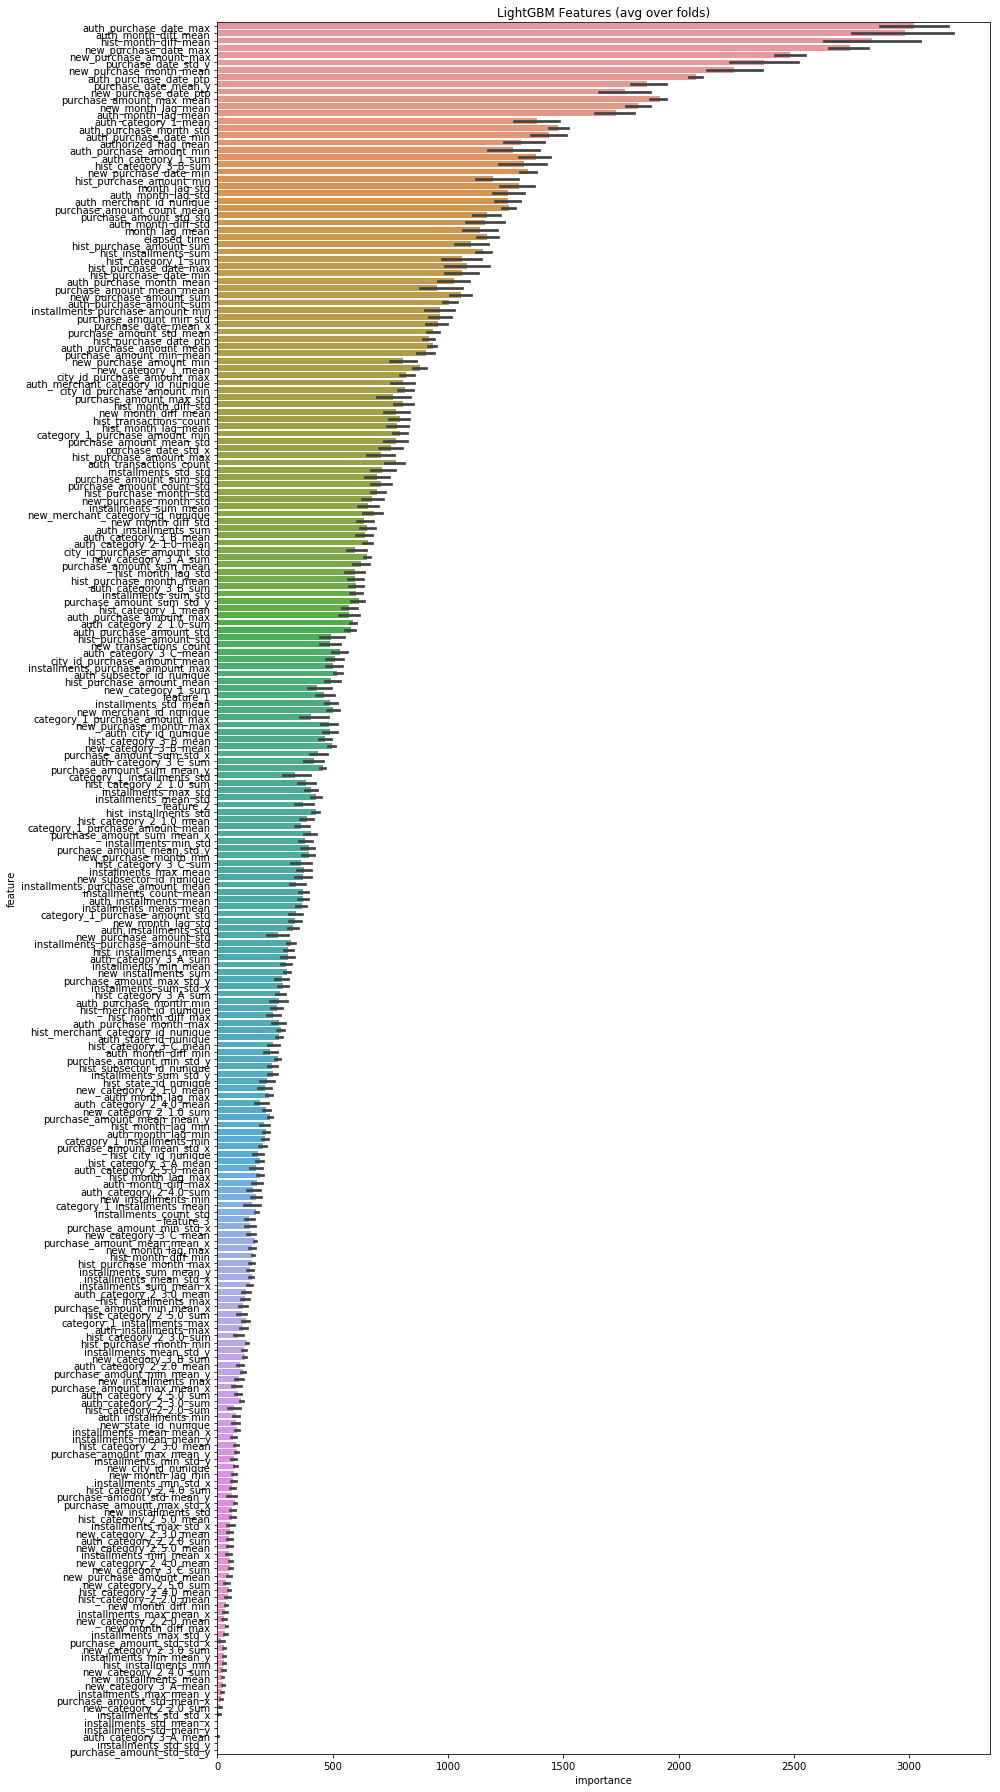

In [39]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission
Now, we just need to prepare the submission file:

In [40]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [41]:
#[1050]	training's rmse: 3.47865	valid_1's rmse: 3.61203     CV score: 3.65527 